# **Título del trabajo:** Aplicación móvil para la recomendación de comidas saludables con funcionalidad de clasificación de imágenes

**2da versión del código para Clasificación de Imágenes: Frutas y Verduras*

**Curso:** Taller de Construcción de Software Móvil  
**Docente:** Petrlik Azabache, Ivan Carlo  
**Proyecto:** FitBite  
**Grupo:** 1  
**Integrantes:**
- Abanto Salas, Flavia Francesca (19200064)  
- Domínguez Matos, Juan Martín (19200275)  
- Palacios Barrutia, Jeanpiere Julian (19200274)

**Consideraciones**

- El conjunto de imágenes fue cargado a Google Drive. Para poder usar el dataset es necesario activar la conexión con Google Drive y colocar la ruta del dataset.
- Para el entorno de ejecución, se recomienda usar un entorno de ejecución GPU. Esto, debido a su velocidad de procesamiento para varias imágenes de nuestro dataset.

**Diferencias con la versión anterior**

- Se incluyó una sección para mostrar las métricas y un gráfico al respecto. Se usó el reporte de clasificación donde se resumen las métricas de evaluación del rendimiento del modelo de clasificaicón de imágenes.
- Se generó el modelo .tflite. Con el código anterior, se generaba un modelo de PyTorch (.pt), el cual, aun requería su conversión a un modelo de TensorFlow Lite (.tflite). Sin embargo, esta conversión puede generar la pérdida de precisión en la clasificación de imágenes de .pt a .tflite, motivo por el cual, se generó el modelo con TensorFlow Lite directamente.

## 1. Importar librerías necesarias

Las librerías a importar son para el manejo y procesamiento de imágenes (ML). Asimismo, se importan librerías para generar gráficos y obtener métricas del modelo.

In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

## 2. Definir las rutas de las carpetas de imágenes de entrenamiento, validación y prueba

Se ingresa la ruta donde se encuentra el dataset de frutas y verduras para nuestro modelo de clasificación de imágenes.

In [27]:
dataset_dir = "./drive/MyDrive/_v2frutas_verduras"

Se definen cuáles son las rutas donde se encuentran las carpetas de entrenamiento (*train*), prueba (*test*) y validación (*validation*).

In [5]:
train_dir = './drive/MyDrive/_v2frutas_verduras/train'
test_dir = './drive/MyDrive/_v2frutas_verduras/test'
validation_dir = './drive/MyDrive/_v2frutas_verduras/validation'

## 3. Definir los hiperparámetros del modelo

Estos son establecidos antes del entrenamiento de nuestro modelo de clasificación de imágenes.

In [6]:
batch_size = 32
epochs = 10
img_height = 224
img_width = 224
num_classes = 49

## 4. Preprocesar y conocer número de imágenes de las carpetas de entrenamiento, validación y prueba

Para todos los casos, se muestra el número de imágenes a usar para el entrenamiento, prueba y validación. Además, se muestra el número de clases que corresponde a las imágenes encontradas en las rutas de las carpetas de entrenamiento, prueba y validación.

### **Preprocesar las imágenes del conjunto de entrenamiento**

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 9555 images belonging to 49 classes.


### **Preprocesar las imágenes del conjunto de prueba**

In [9]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1225 images belonging to 49 classes.


### **Preprocesar las imágenes del conjunto de validación**

In [11]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False)

Found 1225 images belonging to 49 classes.


## 5. Conocer las clases de imágenes del conjunto de datos

Se crea una función para visualizar la primera imagen de cada clase del dataset. Para ello, se crea un canvas, el cual permitirá generar una imagen de cada una de las clases del dataset. Además, en al función se especifica el nombre de la clase de una imagen, la cual aparecerá en la parte superior de dicha imagen.

In [123]:
from PIL import Image, ImageDraw, ImageFont
import os

def visualize_first_images(data_dir, rows, cols):
    classes = sorted(os.listdir(data_dir))
    images = []
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        img_names = os.listdir(class_dir)
        img_path = os.path.join(class_dir, img_names[0])
        img = Image.open(img_path)
        images.append(img)
    width, height = images[0].size
    # Create canvas for all images
    canvas = Image.new('RGB', (cols*(width+30), rows*(height+20)+30),(255, 255, 255))
    # Paste images onto the canvas and add text
    draw = ImageDraw.Draw(canvas)
    for i, (img, cls) in enumerate(zip(images, classes)):
        row = i // cols
        col = i % cols
        canvas.paste(img, (col*width+col*25, row*(height+20)+20))
        draw.text((col*width+col*25, row*(height+20)), cls.encode('utf-8'), fill=(0,0,0))
    canvas.show()

Para visualizar la primera imagen de las clases, ingresamos la ruta del conjunto de entrenamiento (pudo haber sido del conjunto de validación o prueba, la finalidad es mostrar 1 imagen sobre cada clase). Además, se especifica el número de filas y columnas para desplegar las imágenes de las clases del dataset.

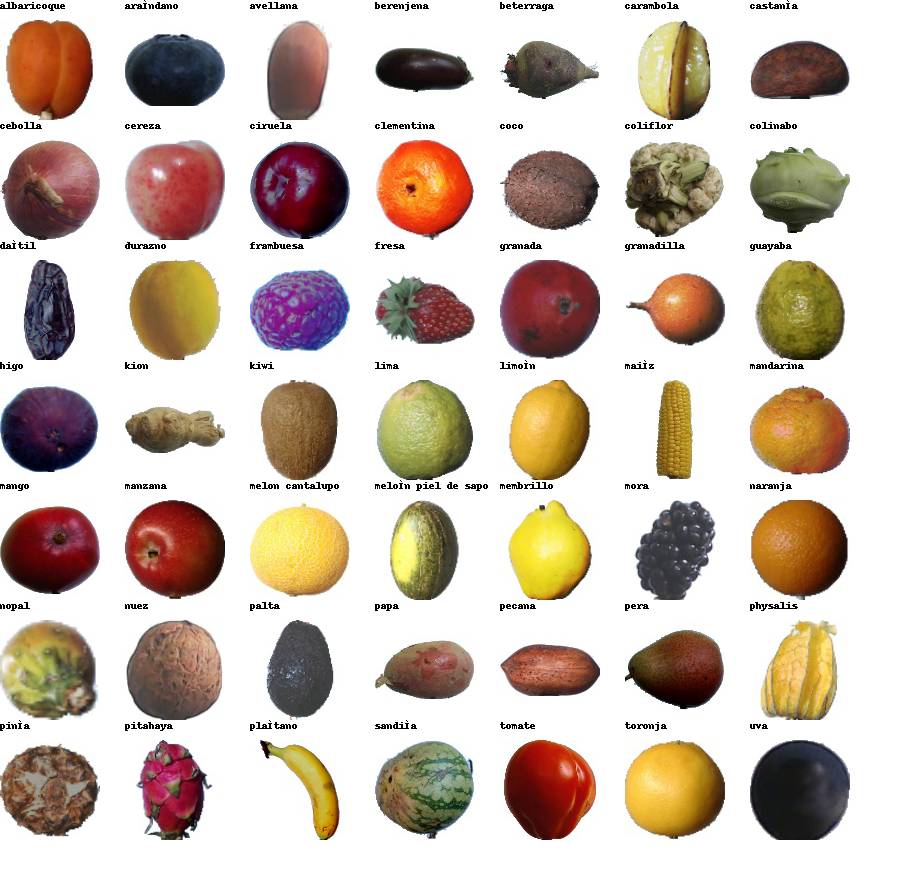

In [124]:
visualize_first_images(train_dir, 7, 7)

## 6. Definir el modelo

### **Crear el modelo**

Se crea un modelo Sequential, por lo que se podrá construir redes neuronales añadiendo capas al modelo.

In [125]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(49, activation='softmax')
])

### **Compilar el modelo**

Para compilar el modelo es necesario ingresar el algoritmo de optimización para ajustar los pesos del modelo. También, la función de pérdida para evaluar el rendimiento del modelo. Finalmente, se ingresa la métrica *accuracy* para evaluar el rendimiento del modelo durante el entrenamiento y la validación.

In [126]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

## 7. Entrenar el modelo

Se entrena el modelo en la variable *history*. Para esto, se usarán 10 épocas.

In [127]:
history = model.fit(train_generator, epochs=epochs, validation_data=val_generator)

Epoch 1/10
299/299 [==============================] - 2077s 7s/step - loss: 0.9118 - accuracy: 0.7673 - val_loss: 0.5852 - val_accuracy: 0.8351
Epoch 2/10
299/299 [==============================] - 1365s 5s/step - loss: 0.0870 - accuracy: 0.9774 - val_loss: 0.5095 - val_accuracy: 0.8727
Epoch 3/10
299/299 [==============================] - 1277s 4s/step - loss: 0.0388 - accuracy: 0.9896 - val_loss: 0.4799 - val_accuracy: 0.9151
Epoch 4/10
299/299 [==============================] - 1302s 4s/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.4848 - val_accuracy: 0.8996
Epoch 5/10
299/299 [==============================] - 1424s 5s/step - loss: 0.0636 - accuracy: 0.9826 - val_loss: 0.5160 - val_accuracy: 0.9045
Epoch 6/10
299/299 [==============================] - 1353s 5s/step - loss: 0.0433 - accuracy: 0.9893 - val_loss: 0.7064 - val_accuracy: 0.8612
Epoch 7/10
299/299 [==============================] - 1291s 4s/step - loss: 0.0319 - accuracy: 0.9914 - val_loss: 0.5893 - val_accuracy:

## 8. Obtener la matriz de confusión

###**Listar los nombres de las clases de las imágenes del dataset**

In [139]:
class_dict = test_generator.class_indices
classes = list(class_dict.keys())
classes.sort()

### **Generar la matriz de confusión**

In [140]:
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(test_generator.classes, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

39/39 [==============================] - 48s 1s/step


### **Plotear la matriz de confusión normalizada**

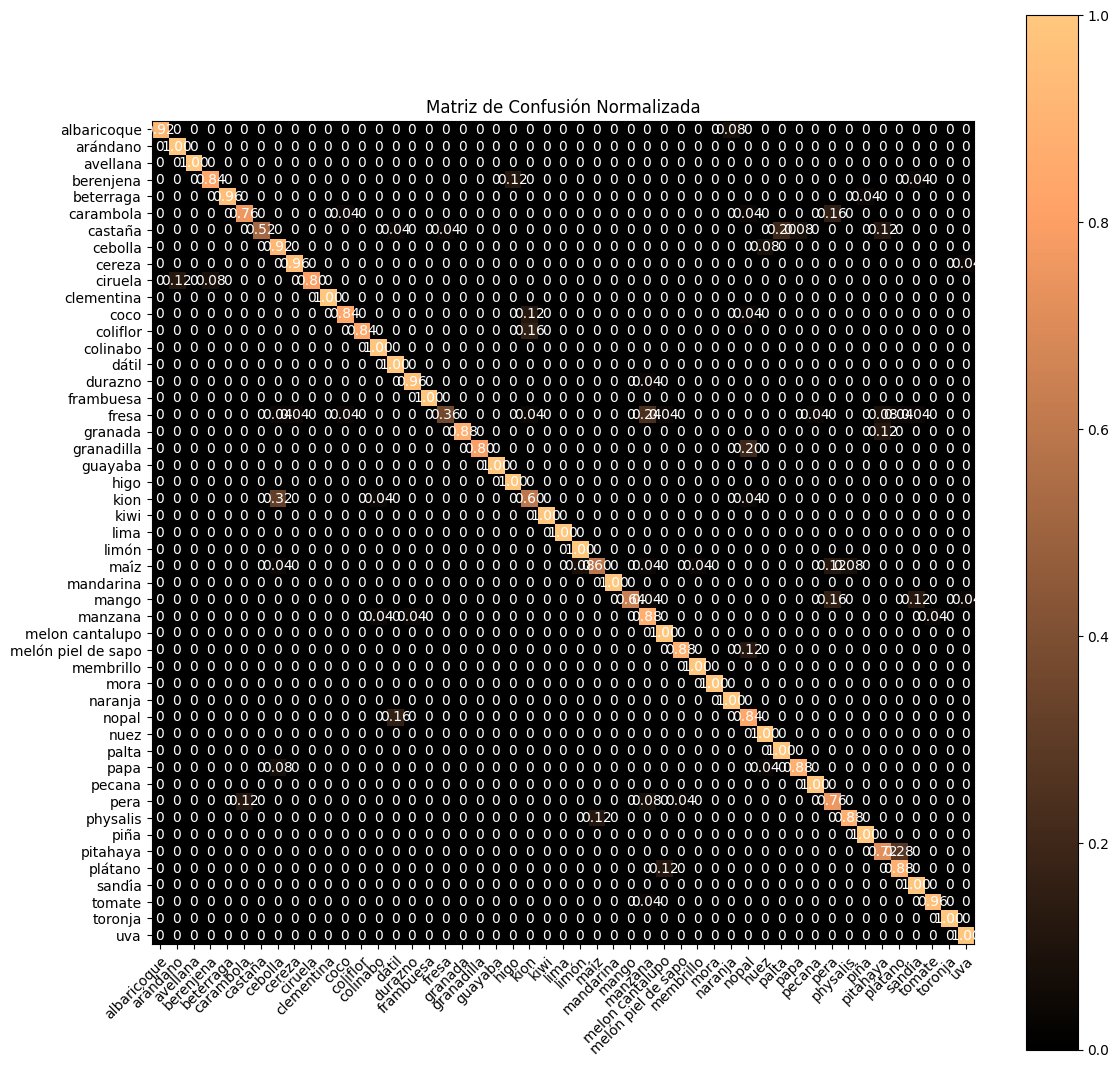

In [149]:
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(cm, cmap='copper')

ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes)
ax.set_yticklabels(classes)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(classes)):
    for j in range(len(classes)):
        if cm[i, j] == 0:
            text = ax.text(j, i, int(cm[i, j]),
                       ha="center", va="center", color="w")
        else:
            text = ax.text(j, i, "{:.2f}".format(cm[i, j]),
                       ha="center", va="center", color="w")

ax.set_title("Matriz de Confusión Normalizada")
fig.tight_layout()
plt.colorbar(im)
plt.show()

## 9. Métricas

### **Accuracy**

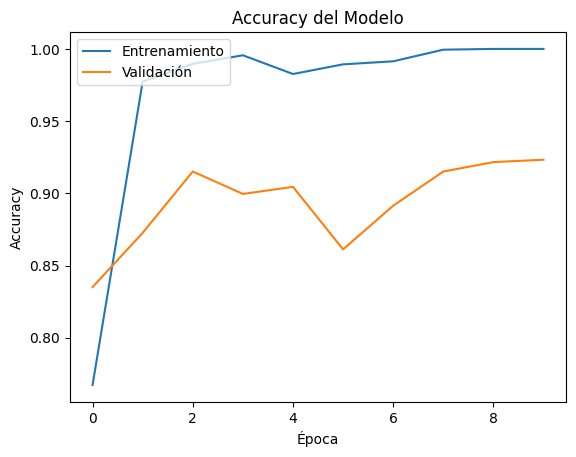

In [150]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy del Modelo')
plt.ylabel('Accuracy')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')
plt.show()

In [151]:
print("Accuracy entrenamiento: ", history.history['accuracy'])

Accuracy entrenamiento:  [0.7673469185829163, 0.9773940443992615, 0.9896389245986938, 0.995604395866394, 0.9826269149780273, 0.9893249869346619, 0.9914181232452393, 0.9994767308235168, 1.0, 1.0]


In [152]:
print("Accuracy validación: ", history.history['val_accuracy'])

Accuracy validación:  [0.8351020216941833, 0.872653067111969, 0.9151020646095276, 0.899591863155365, 0.9044898152351379, 0.8612244725227356, 0.8914285898208618, 0.9151020646095276, 0.9216326475143433, 0.923265278339386]


### **Accuracy Score**

In [153]:
from sklearn.metrics import accuracy_score
accuracyScore = accuracy_score(test_generator.classes, y_pred)
print("Accuracy score: ", accuracyScore)

Accuracy score:  0.8955102040816326


### **Precision Score**

In [157]:
from sklearn.metrics import precision_score
precisionScore = precision_score(test_generator.classes, y_pred, average="macro")
print("Precision score: ", precisionScore)

Precision score:  0.9059892073684299


### **Reporte de Clasificación: Accuracy, Precision, Recall, F1-Score**

In [161]:
from sklearn.metrics import classification_report
target_names = list(test_generator.class_indices.keys())
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

                     precision    recall  f1-score   support

        albaricoque       1.00      0.92      0.96        25
          arándano       0.89      1.00      0.94        25
           avellana       1.00      1.00      1.00        25
          berenjena       0.91      0.84      0.87        25
          beterraga       1.00      0.96      0.98        25
          carambola       0.86      0.76      0.81        25
           castaña       1.00      0.52      0.68        25
            cebolla       0.66      0.92      0.77        25
             cereza       0.96      0.96      0.96        25
            ciruela       1.00      0.80      0.89        25
         clementina       1.00      1.00      1.00        25
               coco       0.91      0.84      0.87        25
           coliflor       1.00      0.84      0.91        25
           colinabo       0.93      1.00      0.96        25
             dátil       0.83      1.00      0.91        25
            durazno    

## 10. Generar del modelo .tflite

In [163]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("mml_clasificador_fitbite.tflite", "wb").write(tflite_model)

44705200